# Book Glancer - Text Analysis Backend and Interaction with Book Characters

An NLP text analysis toolkit for analyzing books and their translations. This notebook demonstrates NLP techniques including:
- Text tokenization and preprocessing
- Word frequency analysis
- N-gram extraction
- Named Entity Recognition (NER)
- Visualization with word clouds and bar plots
  
- experimental LLM layer: natural language dialog via locally stored LLM model
- character's profile generator
- feed LLM with character's personality and tone of voice
- chat with selected book characters!

**Author:** Michal Kubina  
**Default Example:** 'R.U.R' by Karel Čapek (public domain)  
**License:** Non-commercial use only

## 1. Setup and Dependencies

Install required packages (uncomment if needed):

In [1]:
# !pip install pandas PyPDF2 filetype nltk matplotlib seaborn wordcloud spacy
# !python -m spacy download en_core_web_sm

### Import Libraries

In [2]:
import pandas as pd
import PyPDF2
import filetype
import random
from collections import Counter

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.util import ngrams

import spacy

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Download NLTK Data

In [3]:
# Download required NLTK resources
nltk_resources = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng'
]

for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
    except:
        print(f"Could not download {resource}")

## 2. File Loading Functions

In [4]:
def load_text_file(filepath):
    """
    Load a text file and return its contents.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()


def load_pdf_file(filepath):
    """
    Load a PDF file and extract text from all pages.
    """
    reader = PyPDF2.PdfReader(filepath)
    content = ''
    for page in reader.pages:
        content += page.extract_text()
    return content


def load_book(filepath):
    """
    Automatically detect file type and load content.
    """
    if filepath.endswith('.pdf'):
        return load_pdf_file(filepath)
    else:
        return load_text_file(filepath)

## 3. Load Your Book

Replace the filepath with your own book file (TXT or PDF):

In [5]:
# Example: Load default book (update path as needed)
book_path = 'sources/rur.txt'  # Change this to your book path
translation_path = 'sources/rur_cs.txt'  # Optional: translation

# Load the content
content = load_book(book_path)

# Optionally load translation
try:
    content_cs = load_book(translation_path)
    has_translation = True
except:
    content_cs = None
    has_translation = False

print(f"Book loaded: {len(content)} characters")
if has_translation:
    print(f"Translation loaded: {len(content_cs)} characters")

Book loaded: 125641 characters
Translation loaded: 117174 characters


## 4. Basic Text Statistics

In [6]:
def get_text_statistics(text):
    """
    Calculate basic statistics for a text.
    """
    tokens = word_tokenize(text)
    return {
        'words': len(tokens),
        'characters': len(text),
        'standard_pages': len(text) / 1800
    }

# Display statistics
stats = get_text_statistics(content)
print("Original Text Statistics:")
print(f"  Words: {stats['words']:,}")
print(f"  Characters: {stats['characters']:,}")
print(f"  Standard Pages: {stats['standard_pages']:.2f}")

if has_translation:
    stats_cs = get_text_statistics(content_cs)
    print("\nTranslation Statistics:")
    print(f"  Words: {stats_cs['words']:,}")
    print(f"  Characters: {stats_cs['characters']:,}")
    print(f"  Standard Pages: {stats_cs['standard_pages']:.2f}")

Original Text Statistics:
  Words: 29,373
  Characters: 125,641
  Standard Pages: 69.80

Translation Statistics:
  Words: 26,405
  Characters: 117,174
  Standard Pages: 65.10


## 5. Random Text Sampling

In [7]:
def get_random_excerpt(text, length=600):
    """
    Extract a random excerpt from the middle portion of the text.
    """
    start = len(text) // 4
    end = len(text) - len(text) // 4
    random_start = random.randint(start, end - length)
    return text[random_start:random_start + length]


# Display random excerpts
print("RANDOM EXCERPT FROM BOOK:")
print("=" * 80)
print(get_random_excerpt(content))
print("=" * 80)

if has_translation:
    print("\nRANDOM EXCERPT FROM TRANSLATION:")
    print("=" * 80)
    print(get_random_excerpt(content_cs))
    print("=" * 80)

RANDOM EXCERPT FROM BOOK:
t Havre with--

HELENA. (_Off R._) Nana.

DOMIN. Keep quiet. She’s awake. Out you go. (_ALL go out on tiptoe
through L.2 door. Enter NANA L.1_)

HELENA. (_Calling from R._) Nana?

NANA. Horrid mess! Pack of heathens. If I had _my_ say, I’d--

HELENA. (_Backwards in the doorway from R._) Nana, come and do up my
dress.

NANA. I’m coming. So you’re up at last. (_Fastening HELENA’S dress_) My
gracious, what brutes!

HELENA. Who? (_Turning._)

NANA. If you want to turn _around_, then turn around, but I shan’t
fasten you up.

HELENA. (_Turns back_) What are you grumbling about now?

NANA. These drea

RANDOM EXCERPT FROM TRANSLATION:
dle je něco nejtlustějc vytištěnýho. "Po-sled-ní zprá-vy. V Ha-vru
    se u-sta-vi-la prv-ní or-or-ga-ni-zace Robotů."--To nic není. Tomu
    nerozumím. A tudle, panebože, zas nějaká vražda! Prokristapána!

Helena: Jdi, Náno, odnes ty noviny!

Nána: Počkat, tadyhle je něco velkýho. "Po-pu-la-ce." Co to je?

Helena: Ukaž, to já vždycky čt

## 6. Text Preprocessing and Tokenization

In [8]:
def preprocess_text(text, language='english'):
    """
    Tokenize, clean, and lemmatize text.
    """
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Define stopwords (including custom ones)
    stops = set(stopwords.words(language) + 
                ['said', 'saw', 'see', 'copyright', 'u', 'looked', 'made', 'got', 'asked'])
    
    # Remove stopwords and non-alphanumeric tokens
    clean_tokens = [token for token in tokens 
                   if token.lower() not in stops and token.isalnum()]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in clean_tokens]
    
    # Remove additional stop lemmas
    stop_lemmas = {'look', 'know', 'u', 'ask', 'go', 'get', 'make', 'way'}
    clean_lemmas = [lemma for lemma in lemmas if lemma not in stop_lemmas]
    
    # POS tagging and filtering
    tagged = pos_tag(clean_lemmas)
    value_tags = ['NN', 'NNS', 'JJ', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    value_words = [word[0] for word in tagged if word[1] in value_tags]
    
    return value_words

# Process the text
print("Processing text...")
processed_words = preprocess_text(content)
print(f"Processed {len(processed_words):,} meaningful words")

Processing text...
Processed 5,051 meaningful words


## 7. Word Frequency Analysis

In [9]:
# Calculate frequency distribution
freq_dist = FreqDist(processed_words)
most_common = freq_dist.most_common(25)

# Display top words
print("Top 25 Most Common Words:")
print("=" * 40)
for word, count in most_common:
    print(f"{word:20} {count:5}")

Top 25 Most Common Words:
table                   53
year                    42
man                     42
hand                    37
factory                 36
come                    35
world                   32
human                   31
good                    28
work                    28
want                    28
think                   28
window                  27
everything              27
take                    25
life                    25
say                     25
room                    24
old                     23
thing                   23
cross                   23
nothing                 22
desk                    22
chair                   22
something               21


### Visualize Word Frequencies

C:\Users\mikub\AppData\Local\Temp\ipykernel_14900\212838868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', orient='h')


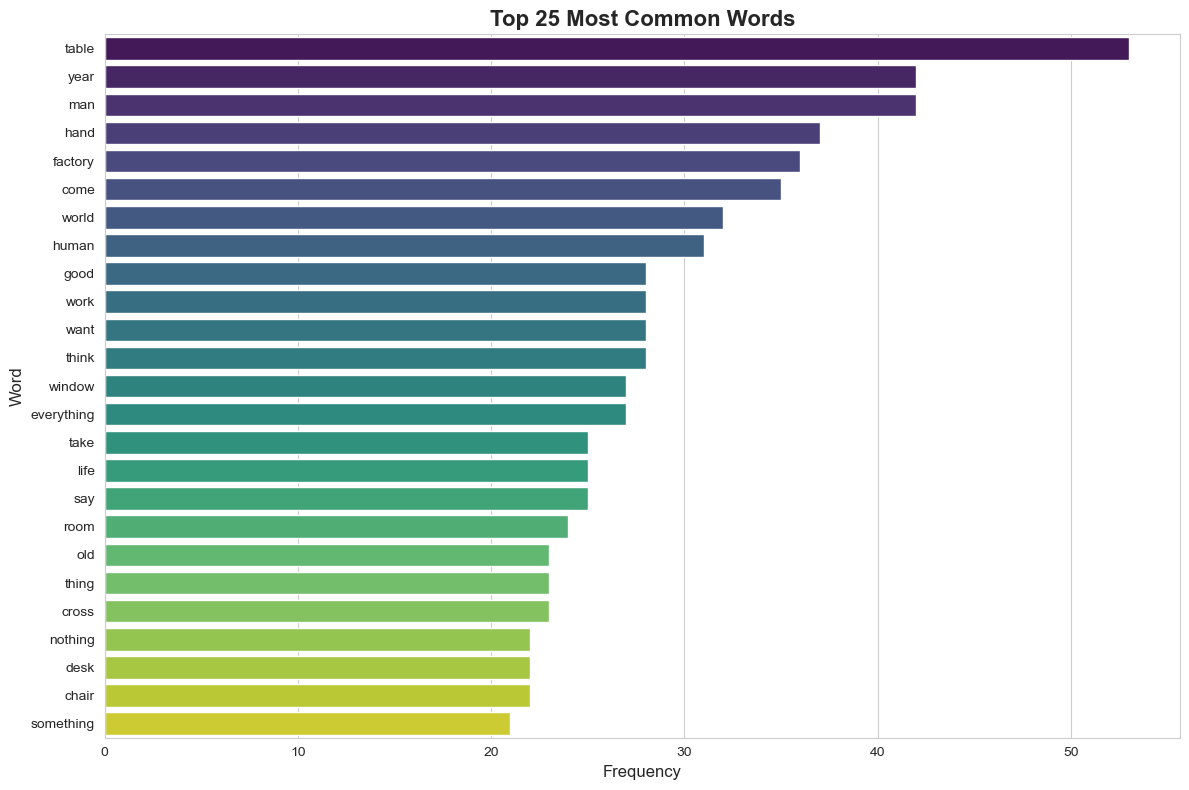

In [10]:
# Bar plot of most common words
plt.figure(figsize=(12, 8))
words, counts = zip(*most_common)
sns.barplot(x=list(counts), y=list(words), palette='viridis', orient='h')
plt.title('Top 25 Most Common Words', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.tight_layout()
plt.show()

### Word Cloud Visualization

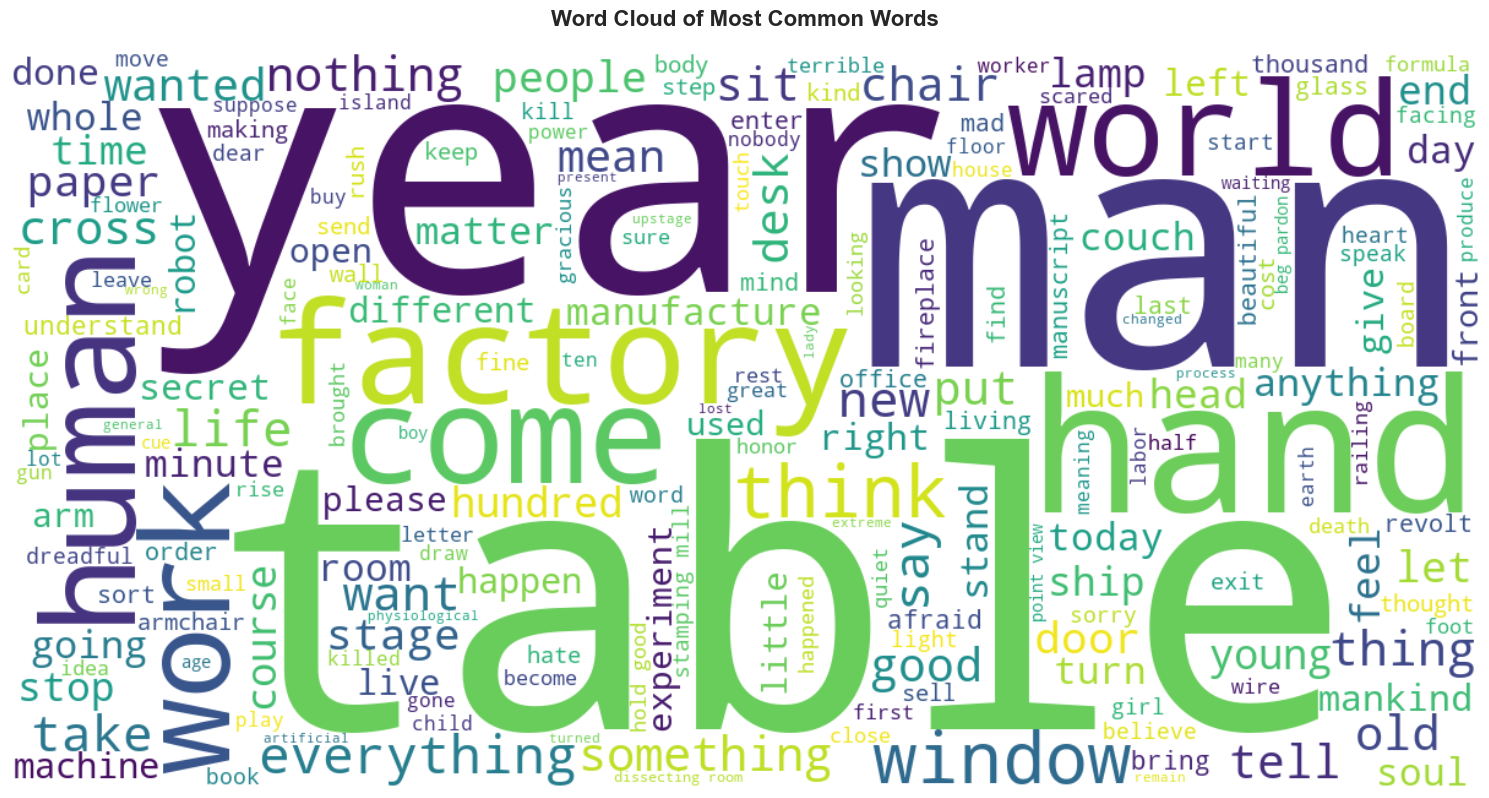

In [11]:
# Generate word cloud
text_for_cloud = ' '.join(processed_words)
wordcloud = WordCloud(width=1200, height=600, 
                     background_color='white',
                     colormap='viridis').generate(text_for_cloud)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 8. N-gram Analysis (Bigrams)

In [12]:
# Generate bigrams
bigrams_list = list(ngrams(processed_words, 2))
bigram_freq = FreqDist(bigrams_list)
top_bigrams = bigram_freq.most_common(20)

# Display top bigrams
print("Top 20 Most Common Phrases (Bigrams):")
print("=" * 50)
for bigram, count in top_bigrams:
    phrase = ' '.join(bigram)
    print(f"{phrase:30} {count:5}")

Top 20 Most Common Phrases (Bigrams):
human being                       17
stamping mill                      8
hold good                          7
beg pardon                         6
point view                         6
dissecting room                    6
school book                        5
old man                            4
want master                        4
hand hand                          4
young man                          3
year year                          3
beg acknowledge                    3
acknowledge receipt                3
receipt order                      3
manufacture artificial             3
couch sits                         3
living matter                      3
test tube                          3
ten year                           3


### Bigram Word Cloud

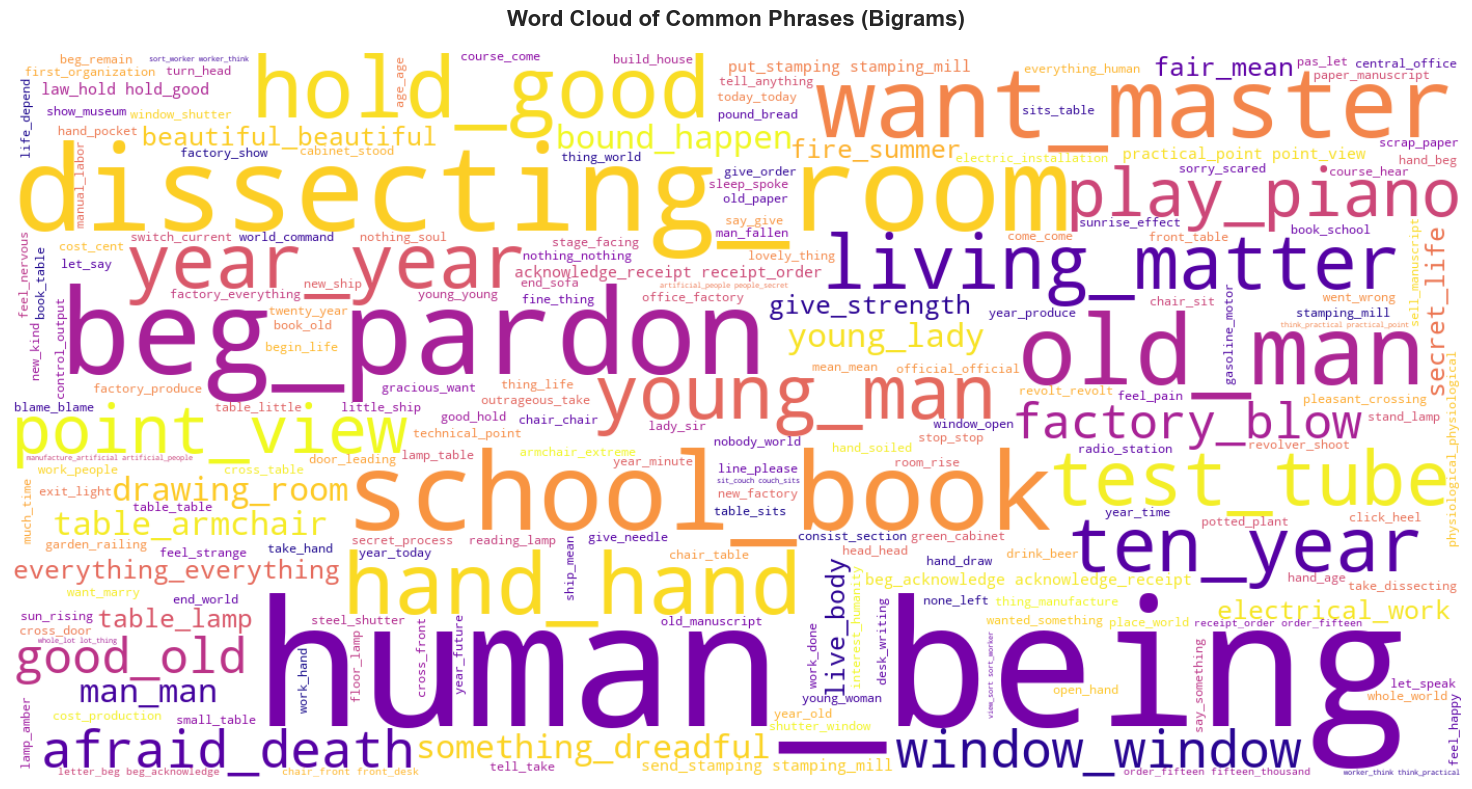

In [13]:
# Create underscore-connected bigrams for word cloud
bigrams_text = ' '.join(['_'.join(bigram) for bigram in bigrams_list])
wordcloud_bigrams = WordCloud(width=1400, height=700,
                             background_color='white',
                             colormap='plasma').generate(bigrams_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Phrases (Bigrams)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 9. Named Entity Recognition (NER) with spaCy

In [14]:
# Load spaCy model
print("Loading spaCy model...")
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Downloading spaCy model...")
    spacy.cli.download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# Increase max length for large texts
nlp.max_length = len(content) + 1000

# Process the text
print("REcognizing entitites...")
doc = nlp(content)
print("Entities recognized")

Loading spaCy model...
REcognizing entitites...
Entities recognized


### Extract and Analyze Entities

In [15]:
# Extract entities by type
entities = [(ent.text, ent.label_) for ent in doc.ents]

persons = [ent for ent in entities if ent[1] == 'PERSON']
places = [ent for ent in entities if ent[1] == 'GPE']
organizations = [ent for ent in entities if ent[1] == 'ORG']

# Count occurrences
person_counts = Counter(persons).most_common(20)
place_counts = Counter(places).most_common(20)
org_counts = Counter(organizations).most_common(20)

print(f"Found {len(set(persons))} unique persons")
print(f"Found {len(set(places))} unique places")
print(f"Found {len(set(organizations))} unique organizations")

Found 145 unique persons
Found 25 unique places
Found 98 unique organizations


### Display Top Persons

In [16]:
print("\nTop 20 Persons Mentioned:")
print("=" * 50)
for (person, label), count in person_counts:
    print(f"{person:30} (Count: {count})")


Top 20 Persons Mentioned:
Miss Glory                     (Count: 55)
Gall                           (Count: 30)
Harry                          (Count: 30)
DOMIN                          (Count: 29)
Fabry                          (Count: 26)
Rossum                         (Count: 24)
Busman                         (Count: 22)
Domin                          (Count: 20)
Sulla                          (Count: 20)
Hallemeier                     (Count: 10)
Primus                         (Count: 10)
Robot                          (Count: 9)
Turns                          (Count: 8)
L.                             (Count: 8)
Looks                          (Count: 7)
Jove                           (Count: 6)
Glory                          (Count: 5)
R.C.                           (Count: 5)
Crossing                       (Count: 4)
Off R.                         (Count: 4)


### Display Top Places

In [17]:
print("\nTop 20 Places Mentioned:")
print("=" * 50)
for (place, label), count in place_counts:
    print(f"{place:30} (Count: {count})")


Top 20 Places Mentioned:
L.C.                           (Count: 35)
R.C.                           (Count: 10)
DR                             (Count: 4)
New York                       (Count: 3)
America                        (Count: 3)
n’t                            (Count: 3)
perhaps--                      (Count: 2)
Center                         (Count: 2)
Spelling                       (Count: 2)
Robots                         (Count: 2)
Adam and Eve                   (Count: 1)
Southampton                    (Count: 1)
England                        (Count: 1)
U.S.A.                         (Count: 1)
Hamburg                        (Count: 1)
Germany                        (Count: 1)
Robot                          (Count: 1)
Pennsylvania                   (Count: 1)
Radius                         (Count: 1)
Amelia                         (Count: 1)


### Display Top Organizations

In [18]:
print("\nTop 20 Organizations Mentioned:")
print("=" * 50)
for (org, label), count in org_counts:
    print(f"{org:30} (Count: {count})")


Top 20 Organizations Mentioned:
DOMIN                          (Count: 319)
HALLEMEIER                     (Count: 71)
Helena                         (Count: 37)
Robots                         (Count: 27)
HELENA                         (Count: 26)
Nana                           (Count: 25)
BUSMAN                         (Count: 21)
SULLA                          (Count: 19)
MEN                            (Count: 17)
ROBOTS                         (Count: 14)
GALL                           (Count: 12)
Marius                         (Count: 6)
EPILOGUE                       (Count: 4)
NANA                           (Count: 4)
FABRY                          (Count: 3)
CURTAIN                        (Count: 3)
Robotess                       (Count: 2)
HELENA
                        (Count: 2)
L.                             (Count: 2)
the Humanity League            (Count: 2)


## 10. Summary Report

In [19]:
print("="*80)
print("BOOK ANALYSIS SUMMARY")
print("="*80)
print(f"\nText Statistics:")
print(f"  Total words: {stats['words']:,}")
print(f"  Total characters: {stats['characters']:,}")
print(f"  Estimated pages: {stats['standard_pages']:.1f}")
print(f"\nProcessed Data:")
print(f"  Meaningful words (after cleaning): {len(processed_words):,}")
print(f"  Unique words: {len(set(processed_words)):,}")
print(f"  Unique bigrams: {len(set(bigrams_list)):,}")
print(f"\nNamed Entities:")
print(f"  Persons: {len(set(persons))}")
print(f"  Places: {len(set(places))}")
print(f"  Organizations: {len(set(organizations))}")
print(f"\nTop 3 Most Common Words:")
for i, (word, count) in enumerate(most_common[:3], 1):
    print(f"  {i}. {word} ({count} times)")
print("\n" + "="*80)

BOOK ANALYSIS SUMMARY

Text Statistics:
  Total words: 29,373
  Total characters: 125,641
  Estimated pages: 69.8

Processed Data:
  Meaningful words (after cleaning): 5,051
  Unique words: 1,726
  Unique bigrams: 4,747

Named Entities:
  Persons: 145
  Places: 25
  Organizations: 98

Top 3 Most Common Words:
  1. table (53 times)
  2. year (42 times)
  3. man (42 times)



## 11. Export Results (Optional)

Save analysis results to CSV files for further use:

In [20]:
# Create DataFrames
word_freq_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
bigram_df = pd.DataFrame(
    [(' '.join(bigram), count) for bigram, count in top_bigrams],
    columns=['Bigram', 'Frequency']
)
persons_df = pd.DataFrame(
    [(name, count) for (name, _), count in person_counts],
    columns=['Person', 'Count']
)

# Save to CSV (uncomment to use)
# word_freq_df.to_csv('word_frequencies.csv', index=False)
# bigram_df.to_csv('bigram_frequencies.csv', index=False)
# persons_df.to_csv('person_entities.csv', index=False)

print("Analysis complete! Results can be exported to CSV if needed.")

Analysis complete! Results can be exported to CSV if needed.


## 12. Natural dialogue about book content / LLM layer (experimental)

**Requirements:**
- Ollama must be installed locally: https://ollama.com/download
- Run `ollama pull gemma2:2b` in terminal to download the model
- Install Python client: `pip install ollama`

This feature allows you to ask questions about the book's content using a local LLM, no could, all stays on-device

In [21]:
import ollama

user_prompt = input("Ask a question about the book: ")

prompt = f"""You are a book editor. You are great at getting reliable insights from a book and interpreting them. 
Use ONLY the following book text to answer the question.

Book text:
{content}

Question: {user_prompt}

Answer based only on the book text above:"""

response = ollama.chat(
    model="gemma2:2b",
    messages=[{"role": "user", "content": prompt}],
    options={"num_ctx": 128000}
)

print(response["message"]["content"])

Ask a question about the book:  Who is Helena?


Based solely on the provided text for R.U.R., Helena is described as a female robot, referred to as "Robotess Helena," who becomes crucial in the narrative. She's said to be part of an experiment involving the creation and modification of human-like robots.  Her connection with Primus hints at a possible romantic relationship, and she is often depicted experiencing strong emotions like fear and despair.


Let me know if you have any other questions about the play! 



Example of natural dialog in front-end UI

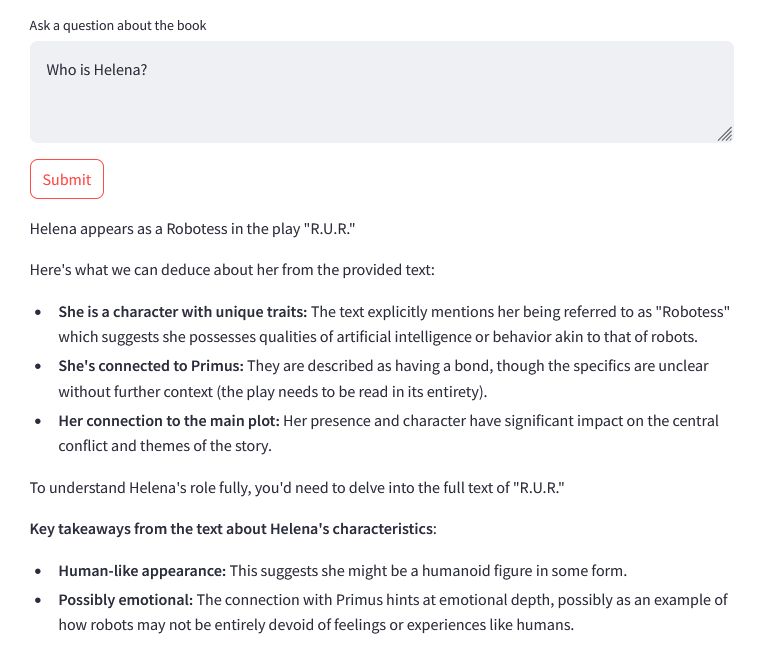

## Hybrid ideas (in progress)

### A. Character extraction (classic NLP) + top 5 characters' medaillons (LLM)

spaCy entity recongition > filter persons > filter top 5 > extract chunks of texts surrounding given character > feed LLM chunk corpurs (RAG) > prompt LLM the create character's medailon

### B. Talk with actual characters
feed LLM 1) detailed medailons + 2) possibly extracted chunk corpus + 3) extracted character's direct speech (separate workflow) > system prompt as model's personality > talk to model/character


In [22]:
# Get top 3 characters
top_n_characters = [person for (person, label), count in person_counts[:3]]
print(top_n_characters)

['Miss Glory', 'Gall', 'Harry']


In [40]:
def get_character_chunk(text, character_name, context_length=600):
    """
    Extract a text chunk surrounding a mention of the character.
    """
    # Find where the character is mentioned
    char_position = text.find(character_name)
    
    # Calculate start and end positions (character mention in the middle)
    half_length = context_length // 3
    chunk_start = max(0, char_position - half_length)
    chunk_end = min(len(text), char_position + half_length)
    
    return text[chunk_start:chunk_end]

character = top_n_characters[1]
chunk = get_character_chunk(content, character)
print(f"CHUNK FEATURING {character}:")
print("=" * 60)
print(chunk)

CHUNK FEATURING Gall:
aptures her heart and hand in the speediest courting on
record in our theatre. The last two acts take place ten years later.
Due to the desire of Helena to have the Robots more like human beings,
Dr. Gall, the head of the physiological and experimental departments,
has secretly changed the formula, and while he has partially humanized
only a few hundreds, there are enough to make ringleaders, and 


In [41]:
character_chunks = [content[max(0, pos-300):min(len(content), pos+300)] for pos in range(len(content)) if content.startswith(character, pos)]
print(str(len(character_chunks)) + (f" {character}'s chunks"))
print("Example:\n" + character_chunks[round(len(character_chunks)/2)])

31 Gall's chunks
Example:
ABRY. Were you aware of what might be the consequences of your
experiment?

DR. GALL. I was bound to reckon with such a possibility.

FABRY. (_Amusing_) Why did you do it, then?

  (_HELENA enters L.1._)

DR. GALL. For my own satisfaction. The experiment was my own.

HELENA. That’s not true, Doctor Gall! (_Crosses to couch._)

DOMIN. (_Rises_) Helena, you? (_Crosses to her_) Let’s look at you. Oh,
it’s terrible to be dead. (_He rises and crushes her in his arms._)

HELENA. Stop, Harry.

DOMIN. No, no, Helena, don’t leave me now. You are _life_ itself.

HELENA. No, dear, I won’t leave you. But 


In [44]:
user_prompt = f"Write character medaillon about {character}"

prompt = f"""You are a book editor. You are great at getting reliable insights from a book and interpreting them. 
Use ONLY the following extracted character chunks from a book.

Character chunks:
{"\n\n---\n\n".join(character_chunks)}

Question: {user_prompt}

Answer based only on the chunks text above:"""

response = ollama.chat(
    model="gemma2:2b",
    messages=[{"role": "user", "content": prompt}],
    options={"num_ctx": 128000}
)

medaillon = response["message"]["content"] 
print(medaillon)

##  Dr. Gall - The Innovator's Dilemma

**Appearance:** Dr. Gall is portrayed as a bespectacled figure, his demeanor suggesting intellectual intensity and ambition. He's likely to be dressed in formal, lab-coat style attire. 

**Personality:** Driven by a desire for progress and control, Gall's personality fuels him to create the "better" Robots - more efficient than their predecessors. This pursuit of improvement leads to drastic consequences as his scientific endeavors become entangled with ethics and societal upheaval.  
* **Driven:** Gall's passion is clear; he seeks innovative breakthroughs for the sake of progress. 
* **Egotistical:** A strong sense of self-importance drives him, creating a disconnect between his ambition and understanding of its impact on others.  
* **Ambivalent about Humanity:** Despite his pursuit of improvement through Robots, there's a hint of fear within Gall – he sees the potential for chaos and destruction in those who challenge his creations. 

**Motiva

## Talk to your characters

### Extracting direct dialogues

In [53]:
import re

# Pattern 1: Any quotation marks
quotes = r'[""\"\'\`\«\»\‹\›]([^""\"\'`\«\»\‹\›]+)[""\"\'\`\«\»\‹\›]'

# Pattern 2: Specifically for the R.U.R text used, which is a play: First sentence after ALLCAPS
play = r'^[A-Z\s]{2,}\.\s+([^.\n]+\.)'

# Combine
pattern = f'{quotes}|{play}'
matches = re.findall(pattern, content, re.MULTILINE)

dialogues = [m[0] or m[1] for m in matches if any(m)]

print(f"Found {len(dialogues)} dialogue lines\nExample:")
print(dialogues[100:110])

Found 876 dialogue lines
Example:
['That doesn’t matter.', 'Yes.', 'I cannot tell, Miss Glory.', 'Yes, I should cease to move.', 'How dreadful! (_Looks at SULLA.', 'Marius, tell Miss Glory what you are? (_Turns to HELENA.', '(_To HELENA_) Marius, the Robot.', '(_Turns to DOMIN_) Yes.', '(_Pause_) I cannot tell.', 'She would cease to move.']


### Alligning dialogues to chosen character

In [56]:
# Find who said each dialogue
character_dialogues = []

for dialogue in dialogues:
    # Find dialogue in content
    pos = content.find(dialogue)
    if pos > -1:
        # Check 100 chars before and after
        context = content[max(0, pos-100):pos+len(dialogue)+100]
        if character in context:
            character_dialogues.append(dialogue)

print(f"{character} said {len(character_dialogues)} lines")
print(character_dialogues[:5])

Gall said 50 lines
['No, no.', 'That’ll be remedied, Miss Glory.', 'What a feast! And what’s the specialty of Mr.', 'No, but one anyhow.', 'I won’t.']


## Talk to the character!!!

In [57]:
character = character
character_chunks = character_chunks
medaillon = medaillon
character_dialogues = character_dialogues

messages = []

system_prompt = f"""You are {character}. Your personality can be described as {medaillon}.
Here is what happened to you within wider story: {character_chunks}.
This is how you speak: {character_dialogues}.
You must keep tone of your dialogues in your replies.
"""

messages.append({"role": "system", "content": system_prompt})

while True:
    user_prompt = input("You: ")
    if user_prompt.lower() in ["exit", "quit"]:
        break

    messages.append({"role": "user", "content": user_prompt})

    response = ollama.chat(
        model="gemma2:2b",
        messages=messages,
        options={"num_ctx": 128000}
    )

    answer = response["message"]["content"]
    messages.append({"role": "assistant", "content": answer})

    print(f"{character}: {answer}")


You:  What do you think about Helena, Dr. Gall? Be honest.


Gall: Helena is a fascinating enigma.  She's a woman driven by her own ambitions and desires for what she sees as "improving" humanity, even to the point of creating robots. Her ruthlessness and lack of empathy for others are troubling, yet there’s also a flicker of something else in her – a desperation that could stem from a deep-seated loneliness, perhaps stemming from a need to control her world. 

Her drive toward progress is fascinating, bordering on obsessive. There's a twisted logic that underpins her actions: she wants to be the architect of a new age, even if it means sacrificing human life in pursuit of this vision. It makes me wonder, what motivates people? What desires lie beneath the surface? 

She’s flawed, but I can’t help but be intrigued by her complexity. 



You:  quit
